# Firing rate during nosepoke

In [46]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [50]:
def fr_dic_formaton(Session, mouse, Kilosort):    
    KSdir = f"D:\\{mouse}_S{Session}\\{Kilosort}\\"
    ##############################################################################################

    spiketimesfile = KSdir+"spike_times.npy"  
    spiketimes = np.load(spiketimesfile)
    clusterfile = KSdir+"spike_clusters.npy"
    spikeclusters = np.load(clusterfile) 
    Clusterinfofile = KSdir+"cluster_info.tsv"
    Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t')
    goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
    goods = []
    for clust in goodclusts :
        goods.append(clust)
    goodspiketimes = {}
    spikethresh = 1000
    for goodunit in goods : 
        goodinds = np.where(spikeclusters==goodunit)[0]
        if goodinds.shape[0] > spikethresh : 
            goodspiketimes[goodunit] = spiketimes[goodinds]
    ##############################################################################################

    matfile = f"D:\\{mouse}_S{Session}\\Behaviour.mat"
    EvaBehavior = loadmat(matfile)
    TestSocialSampleWindowPerTrial = load_behavioral_event(12)
    samplplimg_rate = 20*1000 #20 kHz
    beforesamples = 0*samplplimg_rate # 0 sec (expressed in samples for a 20khz sampling rate)
    aftersamples = 0*samplplimg_rate # 0 sec
    eventlength = 0.25*samplplimg_rate # 0.25 s
    binsize = 0.25*samplplimg_rate
    bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)
    spikes_dic = {}
    psth_dic = {}
    for block in [1,2,3]:
        blockdic = {}
        unitspikes = {}
        eventhists = {}

        n_trials = TestSocialSampleWindowPerTrial[block].shape[0]

        for unit in goodspiketimes.keys(): 

            unitspikes[unit] = {}
            eventhists[unit] = np.zeros(bins.shape[0]-1)

            for event in np.arange(n_trials) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1] # for s36: -(0.25*20000) # since window is 500 for some reason
                
                cond1 = np.where(goodspiketimes[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes[unit][event] = goodspiketimes[unit][np.intersect1d(cond1,cond2)].astype(int)-onset
                
                # PSTH
                n = np.histogram(unitspikes[unit][event], bins=bins)[0] # count spikes
                eventhists[unit]+=n
            eventhists[unit] = (eventhists[unit]/n_trials)*1/(binsize/samplplimg_rate) # Hz
                
        spikes_dic[block] = unitspikes
        psth_dic[block] = eventhists
    save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\fr_analysis\\{mouse}_S{Session}_npoke_fr_dic.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(psth_dic, f)

In [51]:
Sessions = [45,46,10,11]
Ks = ['Kilosort_2024-04-12_162032', 'Kilosort_2024-04-12_180855', 'Kilosort_2024-05-06_144155', 'Kilosort_2024-05-06_154258']
mice = ['3C280', '3C280', '3C290', '3C290']

In [52]:
for i in range(len(Sessions)):
    fr_dic_formaton(Session=Sessions[i], mouse=mice[i], Kilosort=Ks[i])

In [53]:
block_1 = []
block_2 = []
block_3 = []
blocks_fr = [block_1, block_2,block_3]
for i in range(len(Sessions)):
    Session=Sessions[i]
    mouse=mice[i]
    save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\fr_analysis\\{mouse}_S{Session}_npoke_fr_dic.pkl'
    with open(save_path, 'rb') as f:
        npoke_fr_dic = pickle.load(f)
    for block in [1,2,3]:
        for unit in npoke_fr_dic[block].keys():
            blocks_fr[block-1].append(npoke_fr_dic[block][unit][0])
    

In [56]:
len(blocks_fr[0]),len(blocks_fr[1]),len(blocks_fr[2])

(126, 126, 126)

In [57]:
pulled_fr = []
for block in [1,2,3]:
    pulled_fr.extend(blocks_fr[block-1])


In [60]:
pulled_fr

[6.133333333333334,
 7.866666666666666,
 13.6,
 20.4,
 5.333333333333333,
 6.133333333333334,
 31.066666666666666,
 12.0,
 12.4,
 2.0,
 0.5333333333333333,
 0.0,
 0.5333333333333333,
 0.13333333333333333,
 0.0,
 0.13333333333333333,
 0.4,
 0.13333333333333333,
 1.4666666666666666,
 2.533333333333333,
 4.0,
 3.6,
 1.7333333333333334,
 1.8666666666666667,
 1.0666666666666667,
 1.2,
 9.066666666666666,
 21.6,
 13.6,
 23.466666666666665,
 10.0,
 10.533333333333333,
 17.2,
 9.466666666666667,
 14.133333333333333,
 8.4,
 2.533333333333333,
 2.8,
 1.2,
 2.4,
 0.9333333333333333,
 4.133333333333334,
 1.0666666666666667,
 0.4,
 0.0,
 0.6666666666666666,
 0.5333333333333333,
 0.0,
 1.6,
 0.26666666666666666,
 0.13333333333333333,
 0.13333333333333333,
 0.26666666666666666,
 0.0,
 0.13333333333333333,
 20.4,
 0.0,
 1.7333333333333334,
 2.0,
 0.13333333333333333,
 0.13333333333333333,
 2.0,
 7.6,
 0.4,
 2.4,
 3.066666666666667,
 7.2,
 1.6,
 0.13333333333333333,
 0.13333333333333333,
 2.13333333333

social vs blank

In [61]:
a = np.array(blocks_fr[0])
b = np.array(blocks_fr[1])
c = np.array(blocks_fr[2])
ab = (a+c)/2

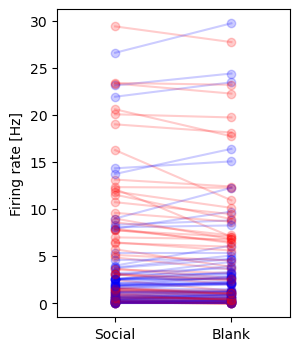

In [72]:
plt.figure(figsize=(3,4)) 
for i in range(len(c)):
    if ab[i] > c[i]:
        plt.plot([0, 1], [ab[i], c[i]], marker='o', linestyle='-', color='red', alpha=0.2)
    else:
        plt.plot([0, 1], [ab[i], c[i]], marker='o', linestyle='-', color='blue', alpha=0.2)
plt.xticks([0,1], labels=['Social', 'Blank'], fontsize=10)
plt.xlim(-0.5,1.5)
plt.ylabel('Firing rate [Hz]')
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\fr_analysis\\{mouse}_S{Session}_social_vs_blank.png', dpi=300, bbox_inches='tight')
plt.show()

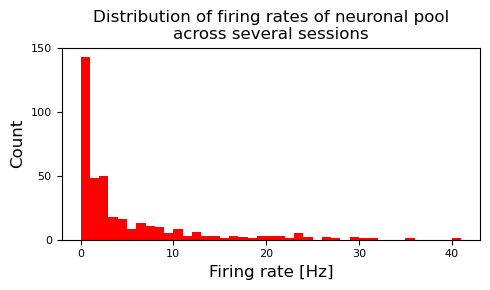

In [59]:
plt.figure(figsize=(5,3)) 
bin_edges = np.arange(np.min(np.array(pulled_fr)), np.max(np.array(pulled_fr))+1, 1)
plt.hist(pulled_fr, alpha=1, bins=bin_edges, color='red')
plt.title(f"Distribution of firing rates of neuronal pool\nacross several sessions")
plt.xlabel('Firing rate [Hz]',  fontsize=12)
plt.ylabel('Count',  fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# plt.xlim(0,70)
plt.tight_layout()
# plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\\\fr_distr.png', dpi=300, bbox_inches='tight')
plt.show()